In [1]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [3]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [4]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [5]:
df_ibis = pd.read_csv('../../data/processed/cleaned_ibis-sg-bencoolen.csv')
df_boss = pd.read_csv('../../data/processed/cleaned_hotel-boss.csv')
df_g = pd.read_csv('../../data/processed/cleaned_hotel-G.csv')
df_village = pd.read_csv('../../data/processed/cleaned_village-hotel-albert-court-by-far-east-hospitality.csv')
df_holiday = pd.read_csv('../../data/processed/cleaned_holiday-inn-express-clarke-quay.csv')


df_combi = pd.concat([df_ibis, df_boss, df_g, df_village, df_holiday])

In [6]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['year'] >= 2015]

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.append('ibis')
sw.append('boss')
sw.append('village')
sw.append('ibis_bencoolen')
stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Stem Review

In [7]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['stem_tokens'] = df_filtered['stem_review'].apply(preprocess)

In [8]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_filtered['stem_tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_filtered['stem_tokens']]

In [48]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_filtered['stem_tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.4089107357371021
The coherence score at topic 3 is 0.419513661325064
The coherence score at topic 4 is 0.4230498313702964
The coherence score at topic 5 is 0.4368466893565405
The coherence score at topic 6 is 0.40275010095716496


In [9]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [10]:
# For Pre-COVID
topics_pre_stem = ldamodel.show_topics(formatted=False, num_words=20)
data_flat_pre = [word for word_list in df_filtered['stem_tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1556627539.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


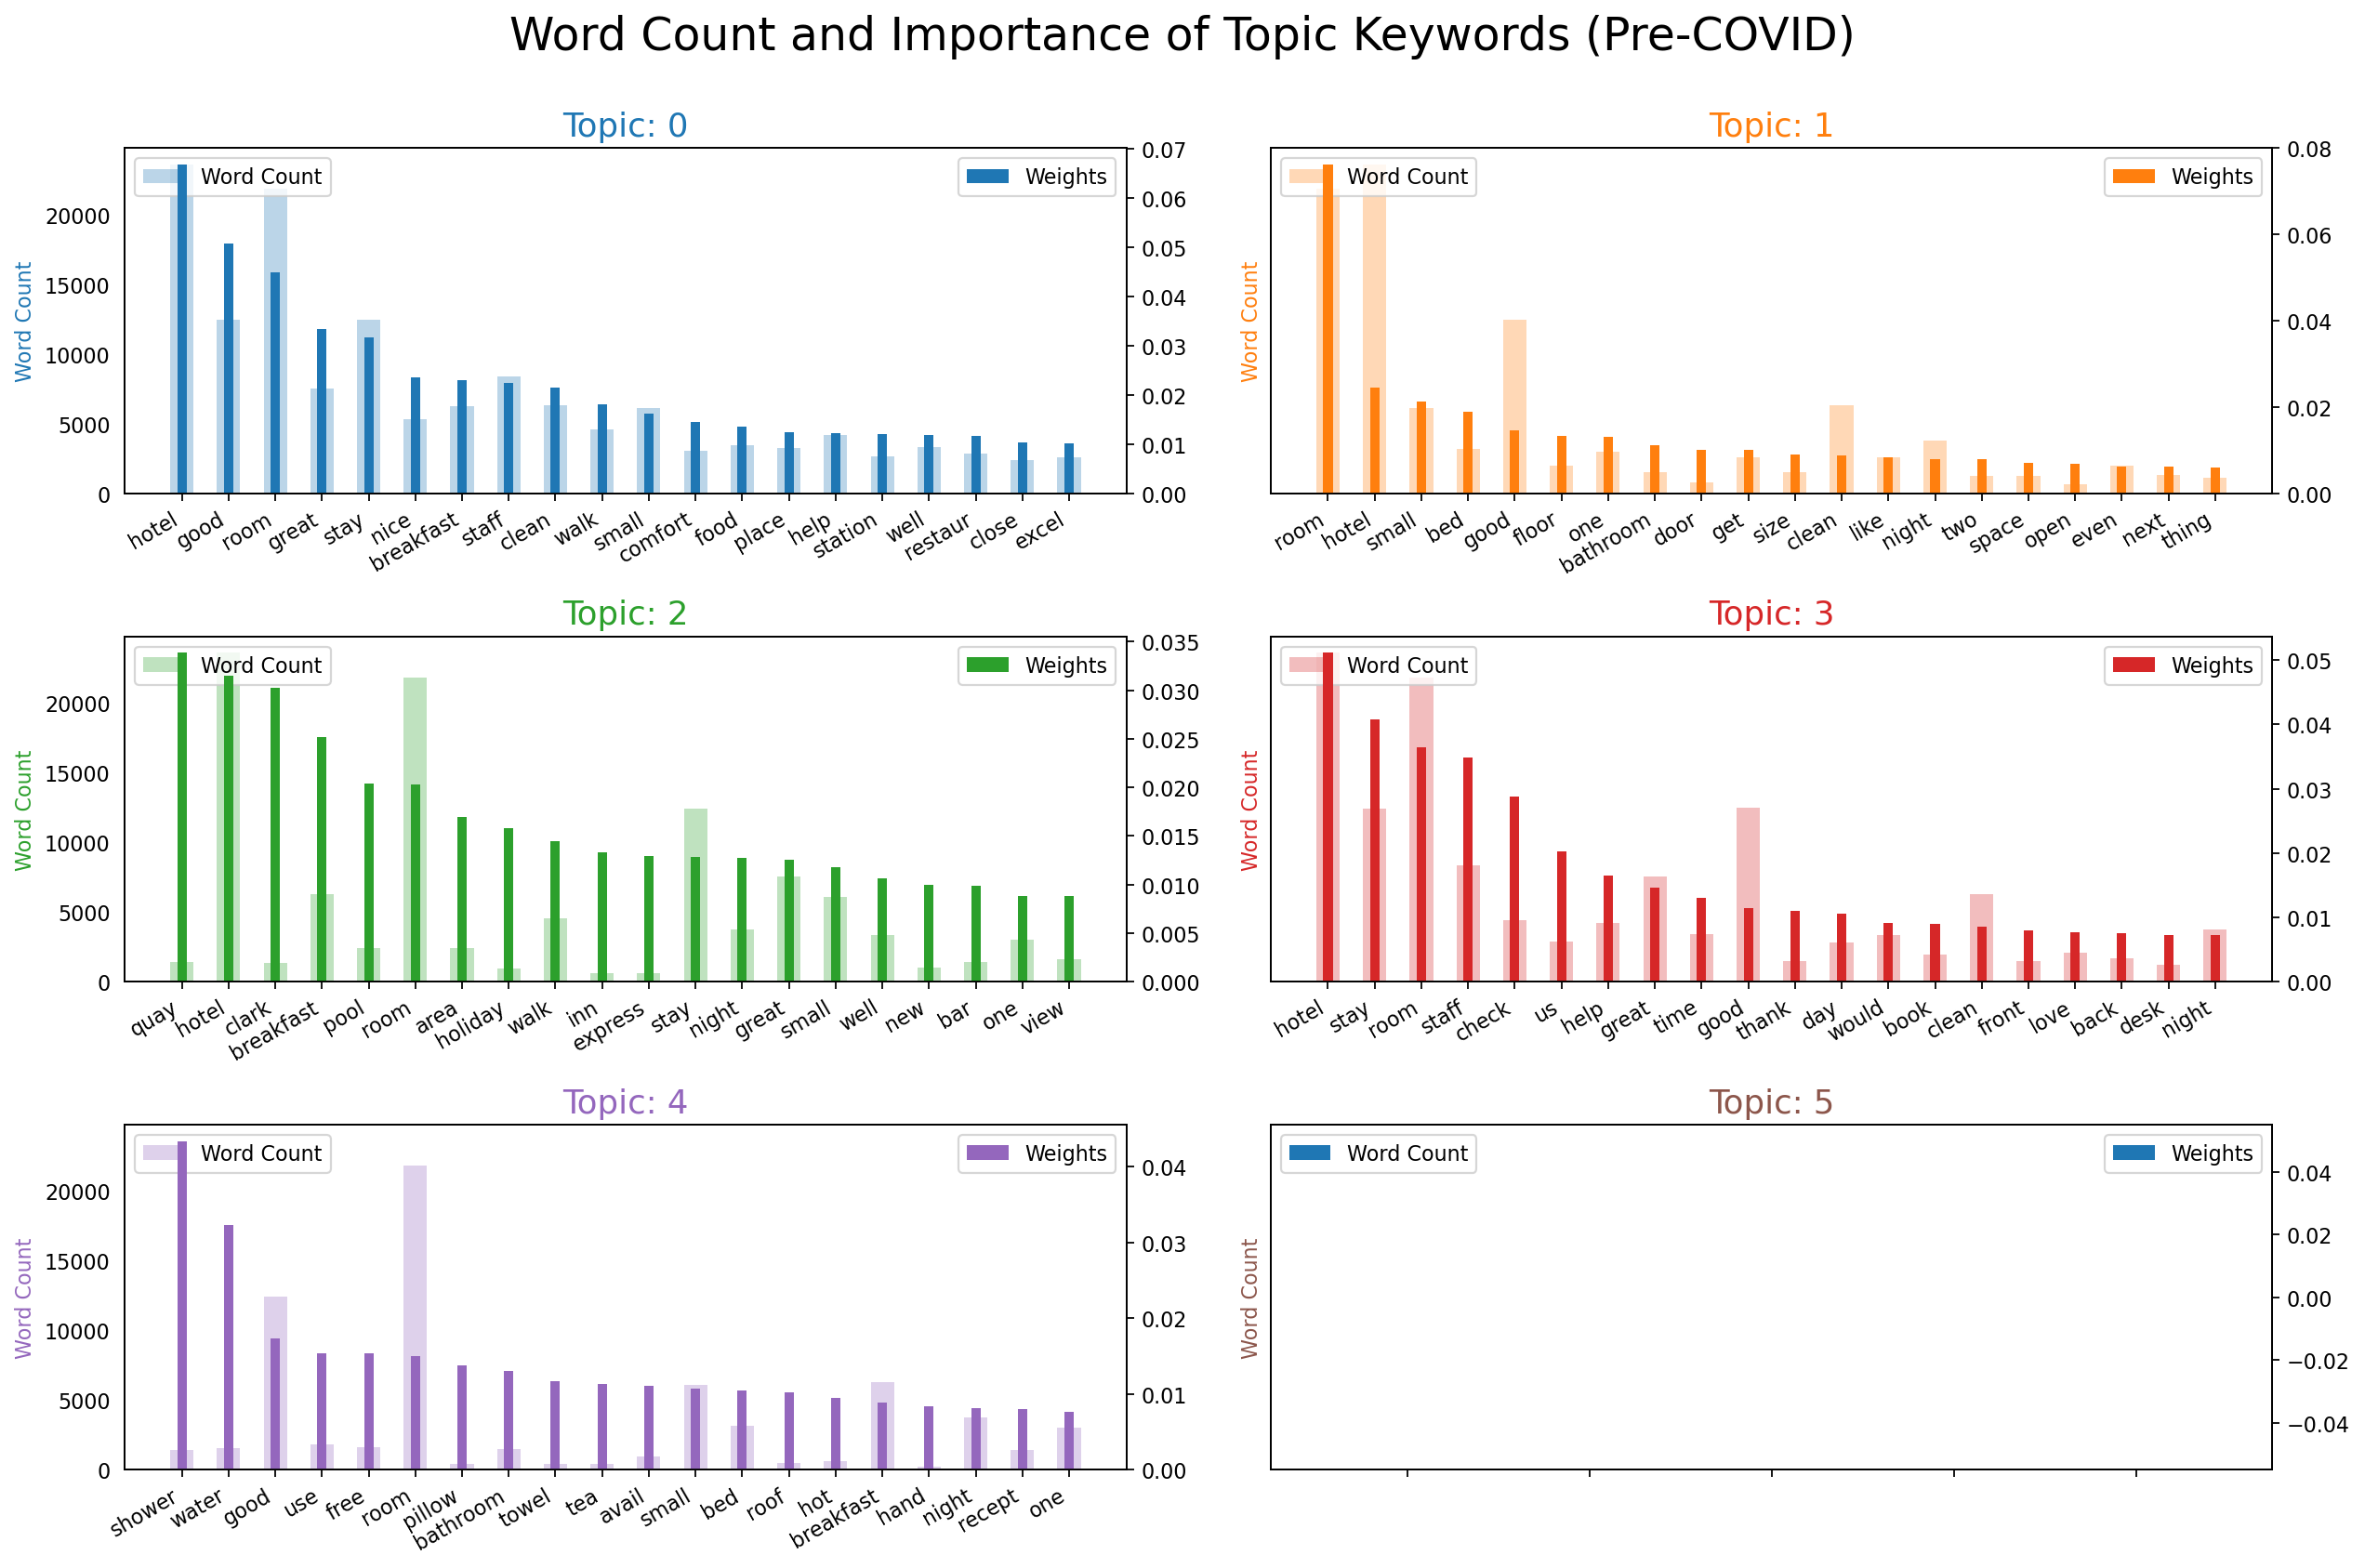

In [11]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre_stem, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

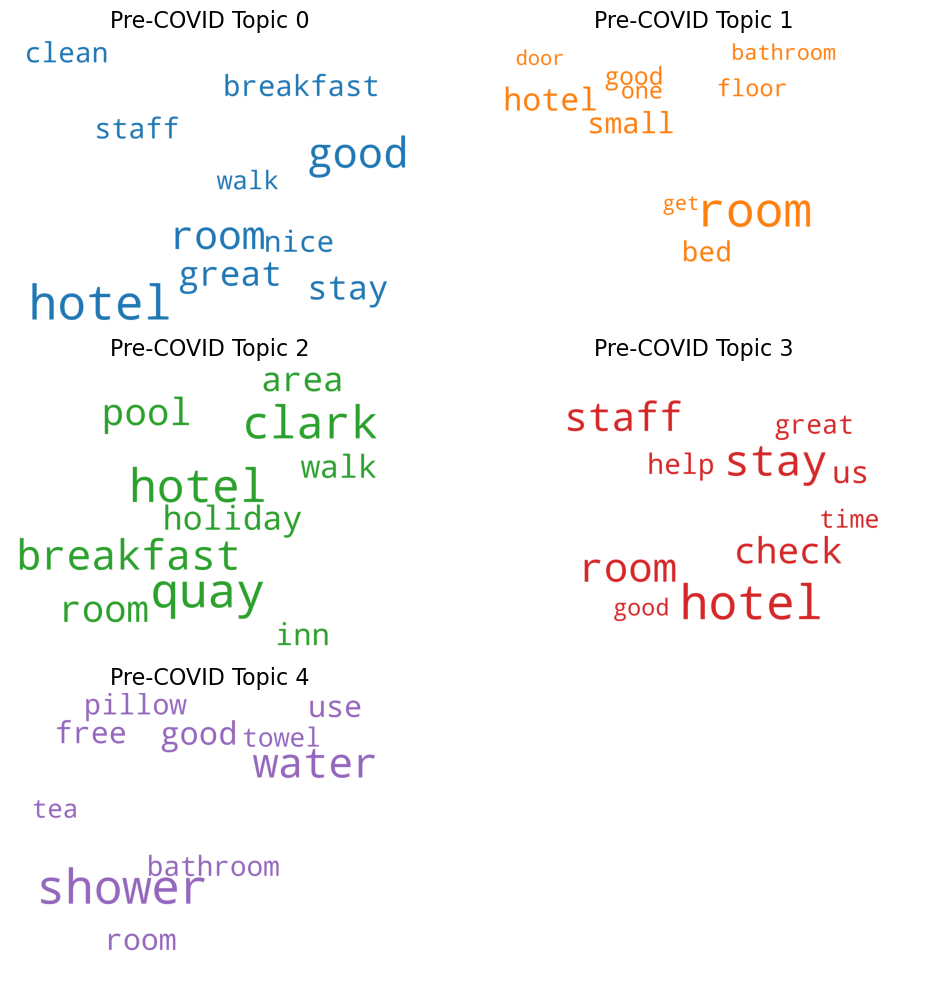

In [13]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [14]:
vis = pyLDAvis.gensim.prepare(topic_model=ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [56]:
clean_data = df_filtered['stem_review'].apply(preprocess)
clean_data = clean_data.apply(lambda x: ' '.join(x))

In [57]:
from nltk import ngrams
bigrams_data = []

for d in clean_data:
    tokens = word_tokenize(d)
    bigrams_data.append(["_".join(w) for w in ngrams(tokens, 2)])


In [58]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_data)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_data]

lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [59]:
# For Pre-COVID
topics_pre_stembi = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_data for word in word_list]

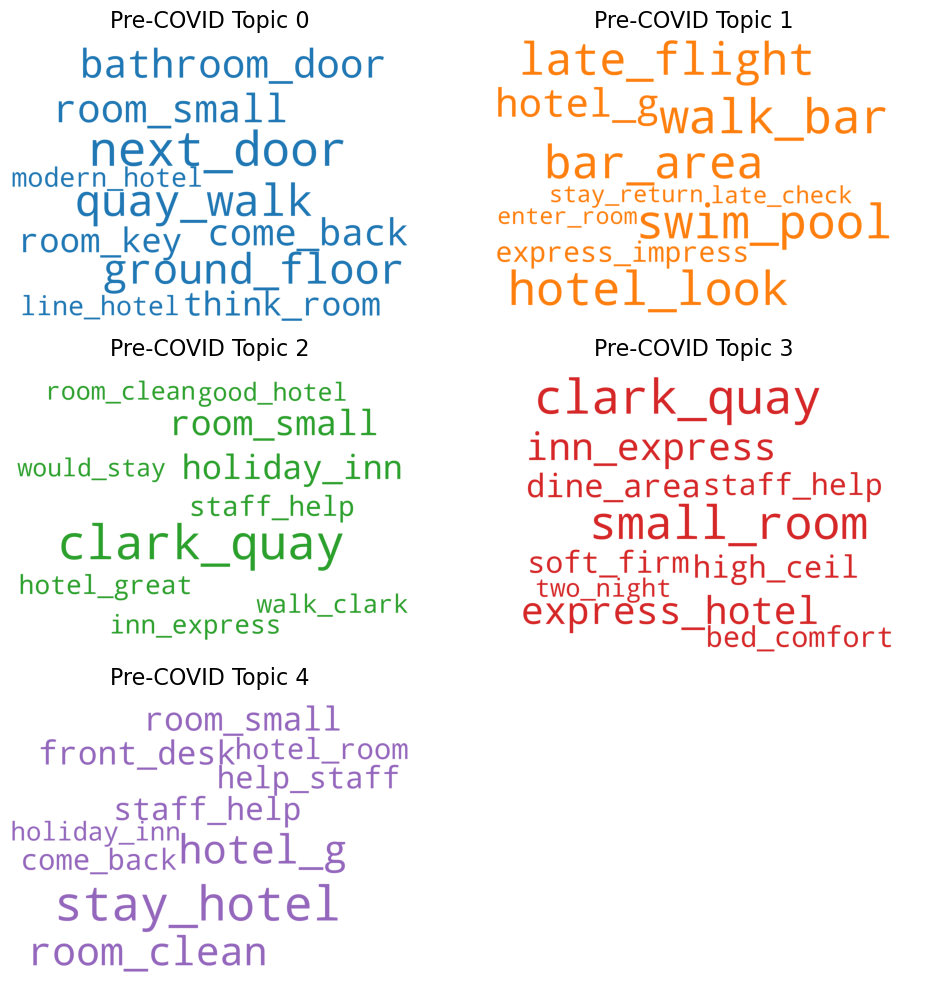

In [60]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [61]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [62]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['lem_tokens'] = df_filtered['lem_review'].apply(preprocess)

In [63]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_filtered['lem_tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_filtered['lem_tokens']]

In [64]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_filtered['lem_tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.37901132660635456
The coherence score at topic 3 is 0.39874886224885236
The coherence score at topic 4 is 0.39508632740739436
The coherence score at topic 5 is 0.37479238963675254
The coherence score at topic 6 is 0.39786571593180237


In [66]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=3, id2word=pre_dict, passes=15)

In [67]:
# For All
topics_pre_lem = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_filtered['lem_tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_15000\478201950.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


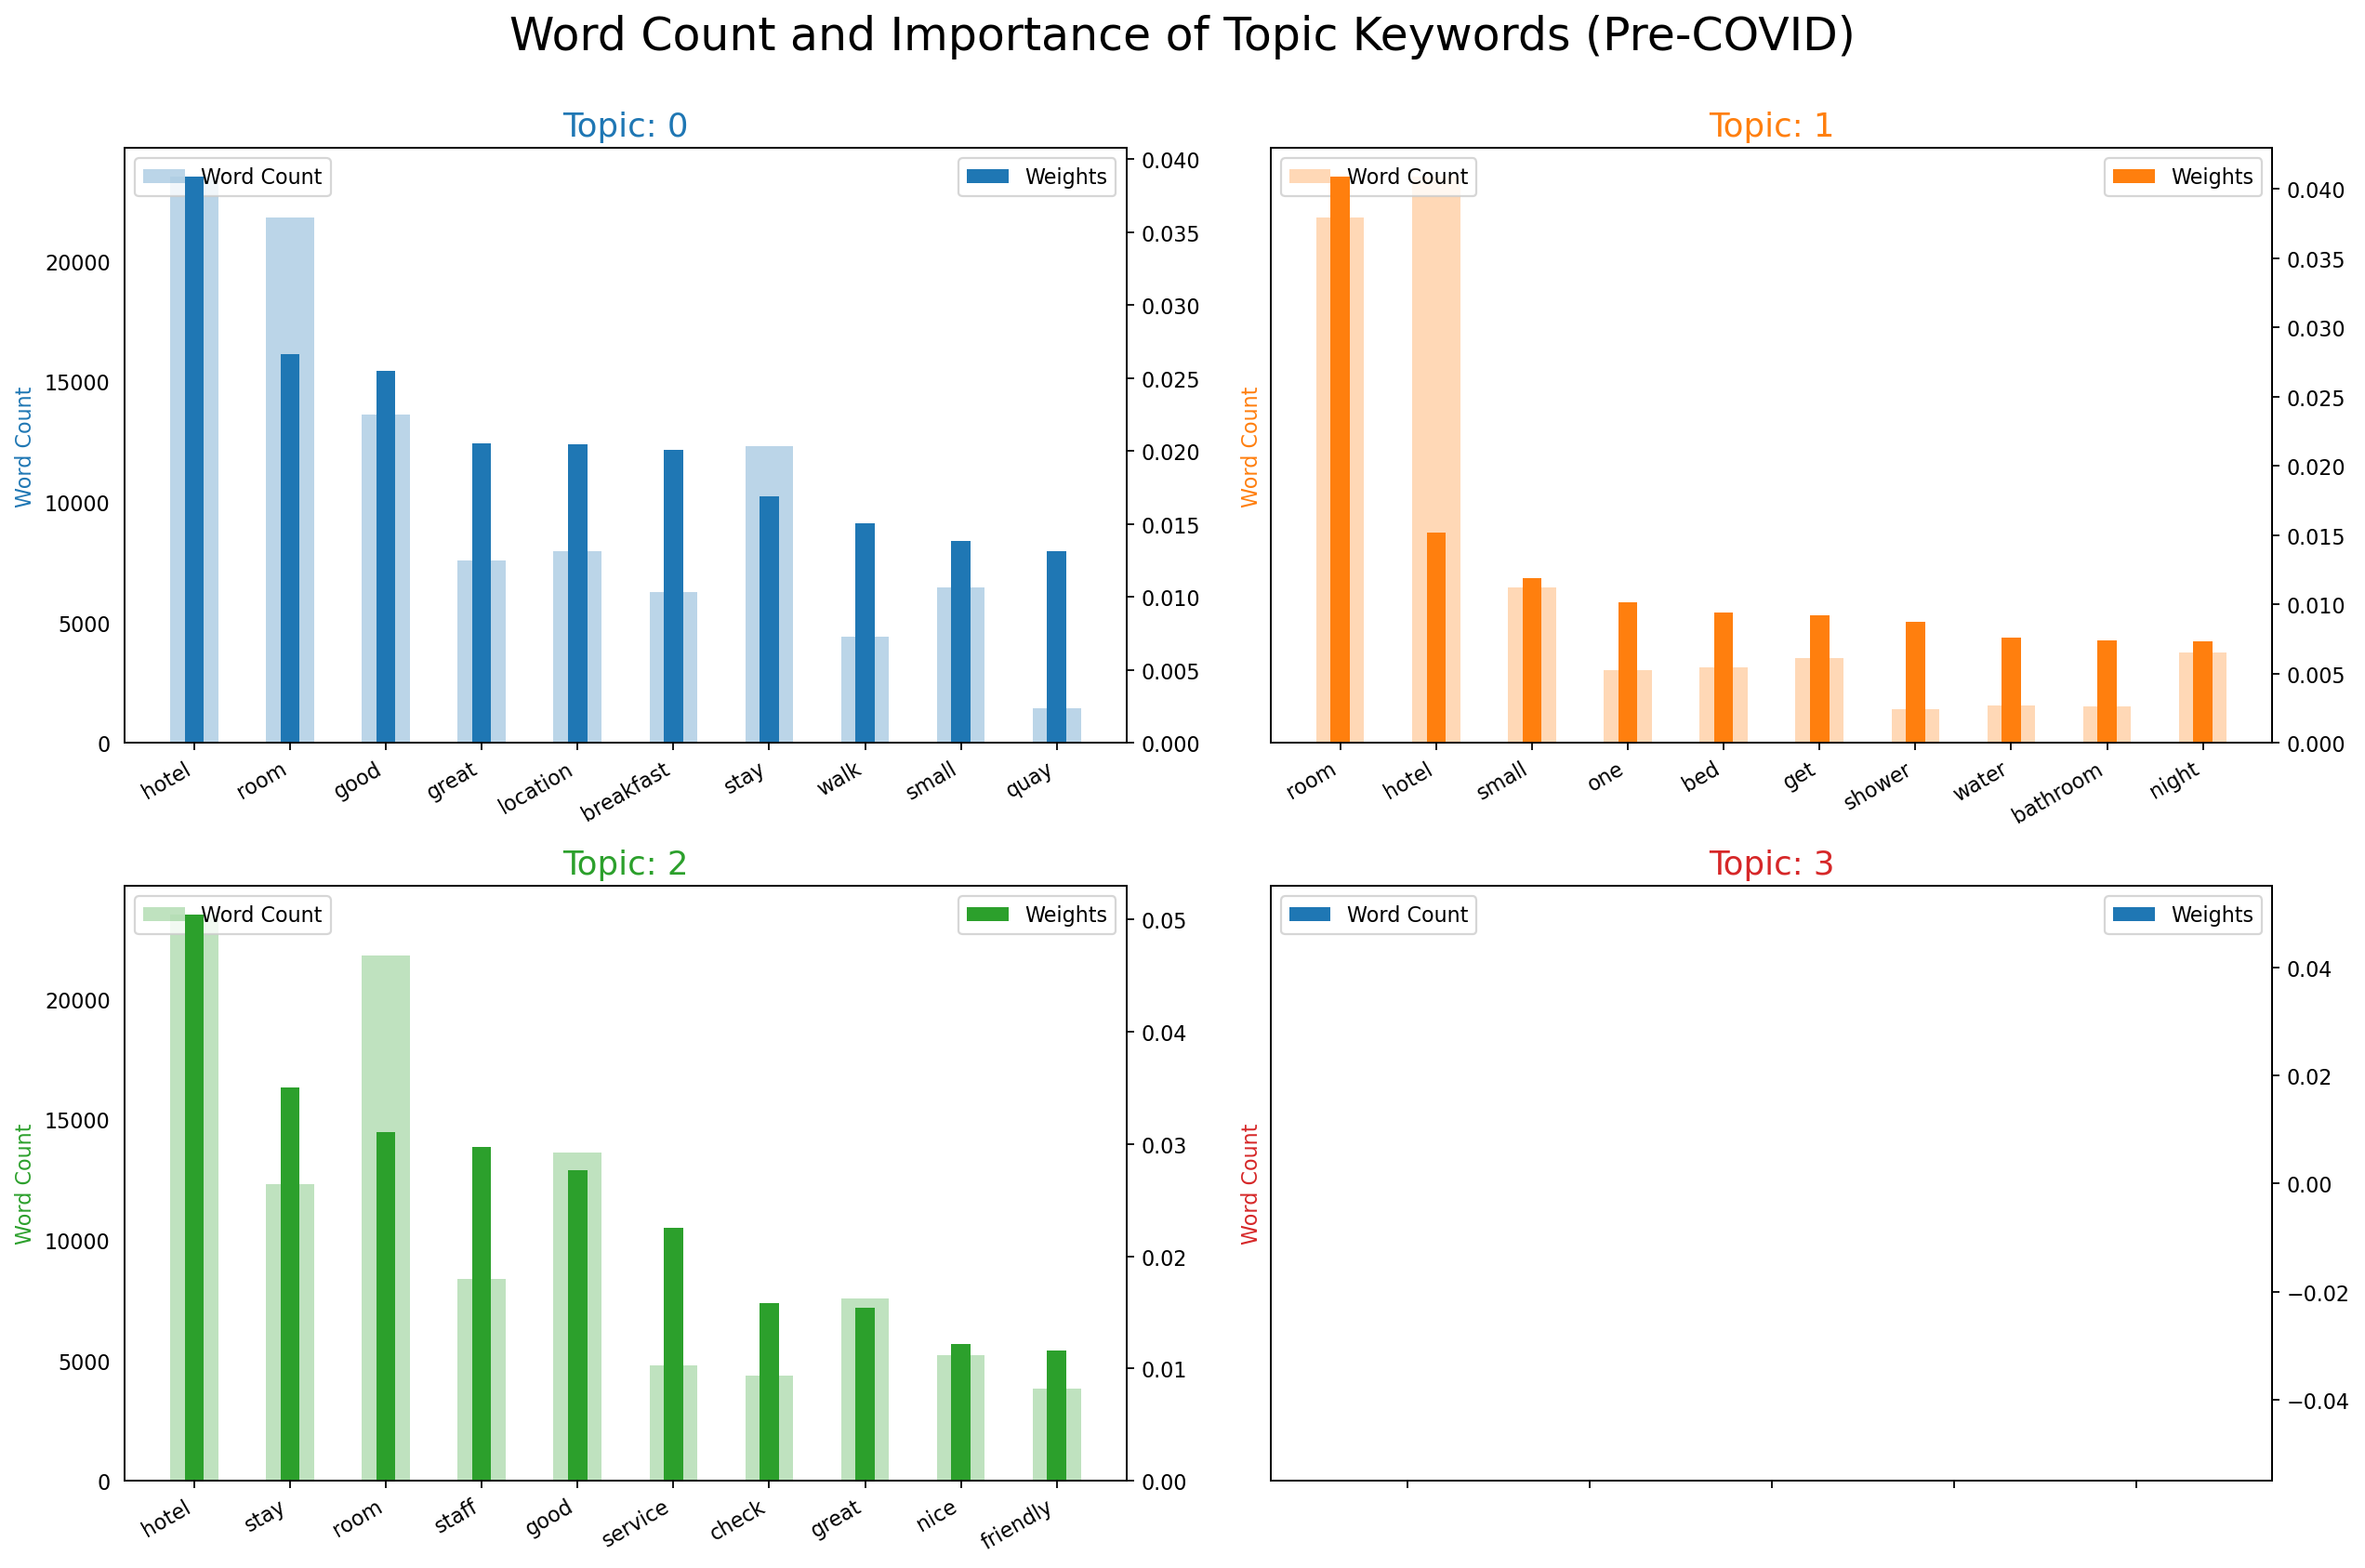

In [69]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre_lem, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

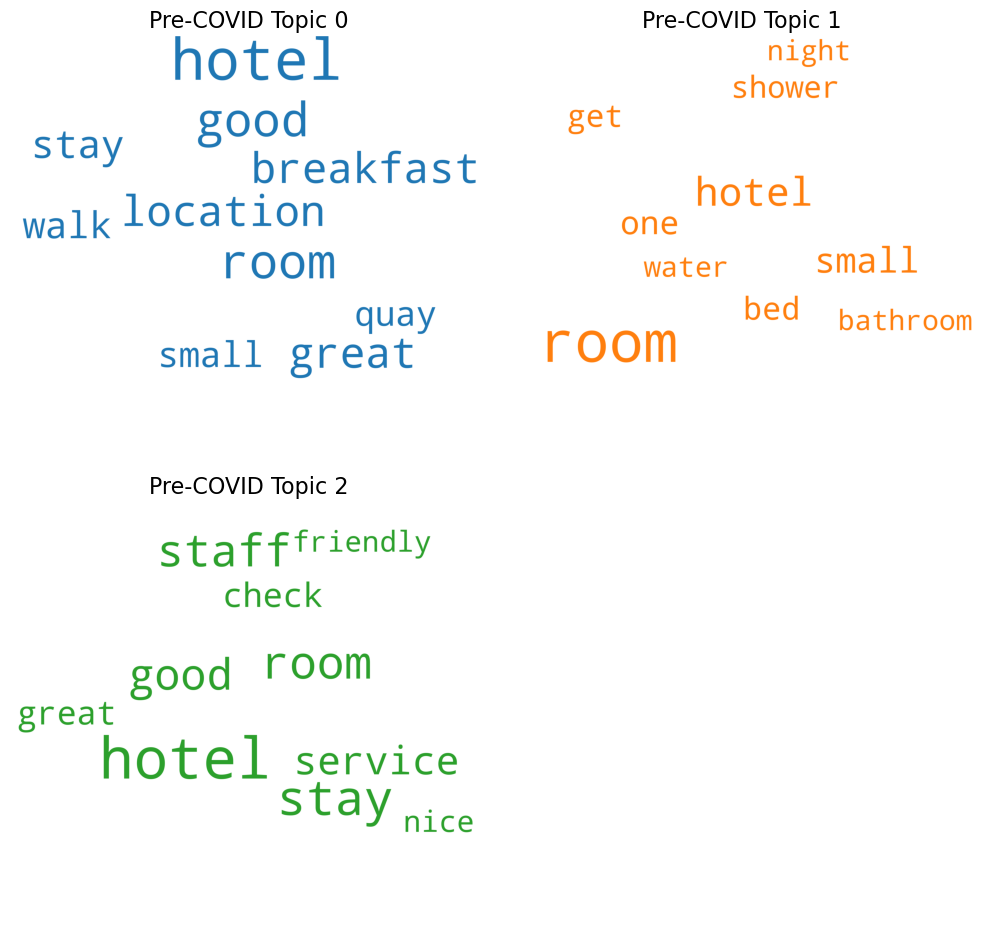

In [70]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [71]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [72]:
clean_data = df_filtered['lem_review'].apply(preprocess)
clean_data = clean_data.apply(lambda x: ' '.join(x))

In [73]:
from nltk import ngrams
bigrams_data = []

for d in clean_data:
    tokens = word_tokenize(d)
    bigrams_data.append(["_".join(w) for w in ngrams(tokens, 2)])


In [76]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_data)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_data]

lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=3, id2word=pre_dict, passes=15)

In [77]:
# For Pre-COVID
topics_pre_lembi = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_data for word in word_list]

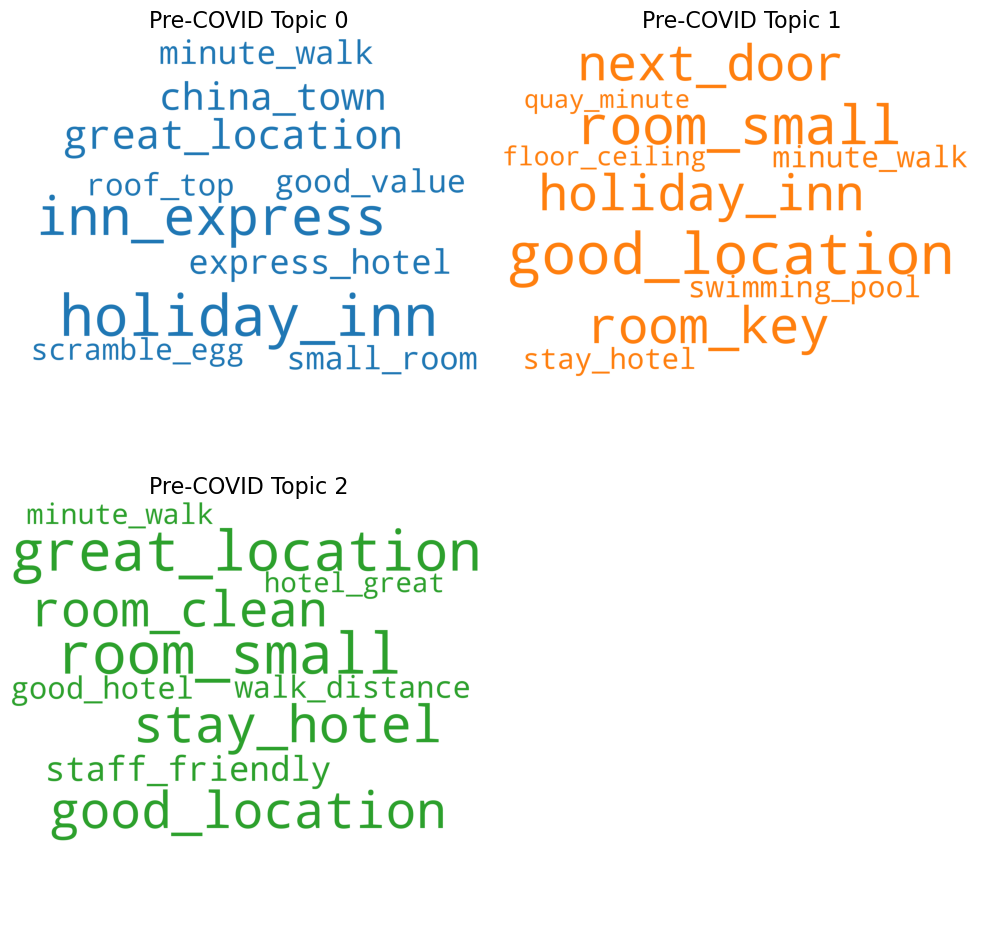

In [78]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [79]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## DP

In [25]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [16]:
# Pass in LDA topics output to remove overlap words by choosing highest prob
def restruct_topics(topics): 
    word_prob_dict = {}
    for i in range(len(topics)):
        topic_num = topics[i][0]
        for word, prob in topics[i][1]:
            if word in word_prob_dict:
                word_prob_dict[word].append((topic_num, prob))
            else:
                ls = [(topic_num, prob)]
                word_prob_dict[word] = ls
    new_dict = {}
    for word in word_prob_dict:
        topic, highest_prob = max(word_prob_dict[word], key = lambda x: x[1])
        if topic in new_dict:
            new_dict[topic].append(word)
        else:
            ls = [word]
            new_dict[topic] = ls
    return new_dict

In [17]:
new_dict = restruct_topics(topics_pre_stem)

In [24]:
new_dict = restruct_topics(topics_pre_stem)
for x in new_dict:
    print(f'length topic {x}: {len(new_dict[x])}')

length topic 0: 14
length topic 1: 15
length topic 3: 14
length topic 2: 12
length topic 4: 13


In [26]:
#takes in the dataframe and appends to each row (aspect, review) pair(s)
def dep_parse(data, new_dict):
    data['aspect_sentiment'] = np.empty((len(data), 0)).tolist()
    for i in range(len(data)):
        sentence = data['combined_review'][i]
        doc = nlp(sentence)
        aspect_sentiment = []
        for word in doc:
            cond = False
            for x in new_dict.values():
                if word.text in x:
                    cond = True
                    break
            if not cond:
                continue
            if word.pos_ == 'NOUN': 
                for j in word.lefts:
                    #print(j, word, j.dep_, j.pos_)
                    if j.dep_ == 'amod' and j.pos_ == 'ADJ':
                        tup = [word, j, list(new_dict.values()).index(x)]
                        #print(tup)
                        aspect_sentiment.append(tup)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':
                            #print(word, j ,k)
                            tup = (word, k.text + ' ' + j.text)
                            aspect_sentiment.append(tup)
                            if (word, j) in aspect_sentiment:
                                aspect_sentiment.remove([word, j, list(new_dict.values()).index(x)])
        data['aspect_sentiment'][i] = aspect_sentiment

In [27]:
df_filtered = df_filtered.reset_index()

In [28]:
dep_parse(df_filtered, new_dict)

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_7432\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [29]:
df_filtered['aspect_sentiment']

0        [[hotel, decent, 0], [room, compact, 1], [bath...
1        [[hotel, Good, 0], [place, great, 0], [hotel, ...
2                     [[place, Good, 0], [place, Good, 0]]
3        [[staff, great, 2], [hotel, neat, 0], [desk, f...
4                       [[door, next, 1], [time, long, 2]]
                               ...                        
14065                                                   []
14066                                                   []
14067                [[hotel, Good, 0], [room, actual, 1]]
14068                                [[room, adjacent, 1]]
14069                                    [[time, next, 2]]
Name: aspect_sentiment, Length: 14070, dtype: object

## Topic Extraction

In [19]:
topics_pre_stem

[(0,
  [('hotel', 0.06676727),
   ('good', 0.05071455),
   ('room', 0.0448263),
   ('great', 0.033398543),
   ('stay', 0.031629194),
   ('nice', 0.023558255),
   ('breakfast', 0.023029268),
   ('staff', 0.022348085),
   ('clean', 0.021452438),
   ('walk', 0.01805263),
   ('small', 0.016128132),
   ('comfort', 0.01458553),
   ('food', 0.013639712),
   ('place', 0.012452389),
   ('help', 0.012174778),
   ('station', 0.012031451),
   ('well', 0.011764409),
   ('restaur', 0.011744109),
   ('close', 0.010299215),
   ('excel', 0.010110413)]),
 (1,
  [('room', 0.0762051),
   ('hotel', 0.024557626),
   ('small', 0.021206615),
   ('bed', 0.01896428),
   ('good', 0.014501052),
   ('floor', 0.0133069875),
   ('one', 0.013077696),
   ('bathroom', 0.01120871),
   ('door', 0.010095451),
   ('get', 0.009984214),
   ('size', 0.008933862),
   ('clean', 0.008750893),
   ('like', 0.008461546),
   ('night', 0.007969285),
   ('two', 0.007935335),
   ('space', 0.0070167533),
   ('open', 0.006952936),
   ('e

In [20]:
top_dict = {}
for i in topics_pre_stem:
    top_dict[i[0]] = []
    for j in i[1]:
        top_dict[i[0]].append(j[0])

('hotel', 0.06676727)
('good', 0.05071455)
('room', 0.0448263)
('great', 0.033398543)
('stay', 0.031629194)
('nice', 0.023558255)
('breakfast', 0.023029268)
('staff', 0.022348085)
('clean', 0.021452438)
('walk', 0.01805263)
('small', 0.016128132)
('comfort', 0.01458553)
('food', 0.013639712)
('place', 0.012452389)
('help', 0.012174778)
('station', 0.012031451)
('well', 0.011764409)
('restaur', 0.011744109)
('close', 0.010299215)
('excel', 0.010110413)
('room', 0.0762051)
('hotel', 0.024557626)
('small', 0.021206615)
('bed', 0.01896428)
('good', 0.014501052)
('floor', 0.0133069875)
('one', 0.013077696)
('bathroom', 0.01120871)
('door', 0.010095451)
('get', 0.009984214)
('size', 0.008933862)
('clean', 0.008750893)
('like', 0.008461546)
('night', 0.007969285)
('two', 0.007935335)
('space', 0.0070167533)
('open', 0.006952936)
('even', 0.006283125)
('next', 0.0062080957)
('thing', 0.0059048114)
('quay', 0.033844154)
('hotel', 0.031447824)
('clark', 0.030259425)
('breakfast', 0.025156973)
('

In [21]:
top_dict

{0: ['hotel',
  'good',
  'room',
  'great',
  'stay',
  'nice',
  'breakfast',
  'staff',
  'clean',
  'walk',
  'small',
  'comfort',
  'food',
  'place',
  'help',
  'station',
  'well',
  'restaur',
  'close',
  'excel'],
 1: ['room',
  'hotel',
  'small',
  'bed',
  'good',
  'floor',
  'one',
  'bathroom',
  'door',
  'get',
  'size',
  'clean',
  'like',
  'night',
  'two',
  'space',
  'open',
  'even',
  'next',
  'thing'],
 2: ['quay',
  'hotel',
  'clark',
  'breakfast',
  'pool',
  'room',
  'area',
  'holiday',
  'walk',
  'inn',
  'express',
  'stay',
  'night',
  'great',
  'small',
  'well',
  'new',
  'bar',
  'one',
  'view'],
 3: ['hotel',
  'stay',
  'room',
  'staff',
  'check',
  'us',
  'help',
  'great',
  'time',
  'good',
  'thank',
  'day',
  'would',
  'book',
  'clean',
  'front',
  'love',
  'back',
  'desk',
  'night'],
 4: ['shower',
  'water',
  'good',
  'use',
  'free',
  'room',
  'pillow',
  'bathroom',
  'towel',
  'tea',
  'avail',
  'small',
  'b

In [22]:
df_res = pd.DataFrame(top_dict)
df_res

0         1          2      3          4
0       hotel      room       quay  hotel     shower
1        good     hotel      hotel   stay      water
2        room     small      clark   room       good
3       great       bed  breakfast  staff        use
4        stay      good       pool  check       free
5        nice     floor       room     us       room
6   breakfast       one       area   help     pillow
7       staff  bathroom    holiday  great   bathroom
8       clean      door       walk   time      towel
9        walk       get        inn   good        tea
10      small      size    express  thank      avail
11    comfort     clean       stay    day      small
12       food      like      night  would        bed
13      place     night      great   book       roof
14       help       two      small  clean        hot
15    station     space       well  front  breakfast
16       well      open        new   love       hand
17    restaur      even        bar   back      night
18      close      next        one   desk     recept
19      excel     thing       view  night        one

In [23]:
df_res.to_csv('3-star LDA.csv')